# Pipeline for Simulating GRNS on Sergio & Packing into Anndata object

First, create the files 

Import the necessary modules

In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import sys
import os
sys.path.append("..")
from pyslingshot.slingshot import Slingshot #for simulating pseudotimes
sys.path.append(os.path.abspath('../SERGIO'))
from SERGIO.sergio import sergio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Simulate the GRN and save the splicing data to files

In [1]:
df = pd.read_csv('../data/input/jens_grn/differentiation.tab', sep='\t', header=None, index_col=None)
bMat = df.values
print(bMat.shape)
#rows and cols correspond to genes and cells (just verify)
# 100 x (6 x 300 ) = 1800 cells
#  100 genes, 6 cell types, 6 bins of 300 cells per cell type
sim = sergio(number_genes=8, number_bins = 3, number_sc = 100, noise_params = 0.2, decays=.8, dt=0.05, dt_splice=0.05, sampling_state = 1, noise_params_splice = 0.07, noise_type='dpd', dynamics=True, bifurcation_matrix= bMat)
sim.build_graph(input_file_taregts ='../data/input/jens_grn/grn.txt', input_file_regs='../data/input/jens_grn/regulators_cid.txt', shared_coop_state=2)
sim.simulate_dynamics()
# final ct matrix is the sum of U and S
#spliced matrix, unspliced, sum of both, pseudotime (probs just a vector bc each element in pseudotime is 1d scalar for 1 cell)
exprU, exprS = sim.getExpressions_dynamics()
exprU_clean_jensgrn = np.concatenate(exprU, axis = 1)
print(exprU_clean_jensgrn)
print(exprU_clean_jensgrn.shape)

exprS_clean_jensgrn = np.concatenate(exprS, axis = 1)
print(f"exprU_clean_jensgrn shape: {exprU_clean_jensgrn.shape}")
print(f"exprS_clean_jensgrn shape: {exprS_clean_jensgrn.shape}")

# Print the number of columns for each row
for i, row in enumerate(exprU_clean_jensgrn):
    print(f"Row {i} of exprU_clean_jensgrn has {len(row)} columns")

for i, row in enumerate(exprS_clean_jensgrn):
    print(f"Row {i} of exprS_clean_jensgrn has {len(row)} columns")

# Optionally save to text files
np.savetxt('exprU_clean_jensgrn_jensgrn.txt', exprU_clean_jensgrn, delimiter=' ', fmt='%f')
np.savetxt('exprS_clean_jensgrn_jensgrn.txt', exprS_clean_jensgrn, delimiter=' ', fmt='%f')


NameError: name 'pd' is not defined

# Compute pseudotimes

First create the txt file from csv to find the pseudotimes

In [3]:
# import os

# def csv_to_txt(input_csv, output_folder="data/output"):
#     os.makedirs(output_folder, exist_ok=True)
#     output_txt = os.path.join(output_folder, os.path.basename(input_csv).replace(".csv", ".txt"))

#     with open(input_csv, 'r') as csv_file, open(output_txt, 'w') as txt_file:
#         for line in csv_file:
#             txt_file.write(line.replace(',', ' '))

#     print(f"Saved to {output_txt}")

# # Example usage in Jupyter Notebook
# input_csv = "--"  # Change this as needed
# csv_to_txt(input_csv)

#questions for wenjun: 
#what is the meaning of all of these instances of simulated csvs? are they all for the same grn and am i supposed to simulate all of them?
#for some reason when I transform the csv to txt, it's missing a single column header due to the nature of the data  
#help me figure out wt is going on w sergio


In [4]:
# data = np.loadtxt( "data_linear.txt" )

#data = np.load("data_bifurcate.npy")
def analyze_txt(input_txt):
    with open(input_txt, 'r') as txt_file:
        expected_columns = None
        for i, line in enumerate(txt_file):
            columns = line.strip().split()  # Split line into columns based on spaces
            num_columns = len(columns)
            
            if expected_columns is None:
                expected_columns = num_columns  # Set initial expected columns
            
            if num_columns != expected_columns:
                print(f"Column mismatch at row {i}: expected {expected_columns}, found {num_columns}")
            
            print(f"Row {i}: {num_columns} columns")  # Print column count for each row

# Example usage
input_txt = 'exprS_clean_jensgrn_jensgrn.txt'  # Replace with your actual TXT file path
analyze_txt(input_txt)

data = np.loadtxt( "exprS_clean_jensgrn_jensgrn.txt" )


Row 0: 300 columns
Row 1: 300 columns
Row 2: 300 columns
Row 3: 300 columns
Row 4: 300 columns
Row 5: 300 columns
Row 6: 300 columns
Row 7: 300 columns


In [5]:
data.shape

(8, 300)

/var/folders/6s/mn0cx1qn7b901qdgrbh6z_hm0000gp/T/ipykernel_10676/369344071.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


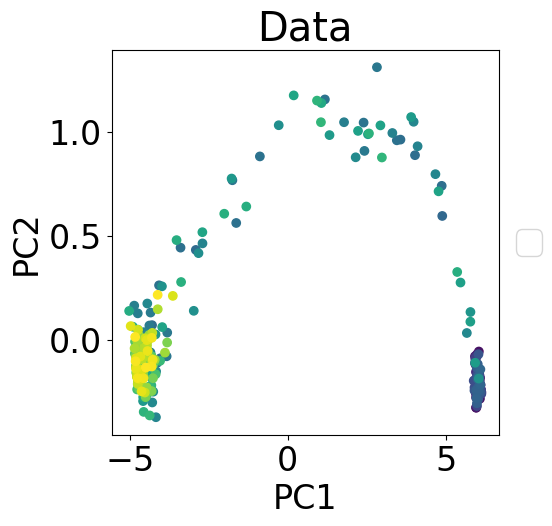

In [6]:
plt.rcParams["figure.figsize"] = (5,5)
        # PCAs:
from sklearn.decomposition import PCA
plt.rcParams["font.size"] = 24
pca = PCA()
Xt_all = pca.fit_transform(np.log2(data.T+1) ) 
plt.scatter(Xt_all[:,0],Xt_all[:,1], c=range(Xt_all.shape[0]) )
#         for j in range(Nt):
#             idx = range(num_cells_per_time*j, num_cells_per_time*(j+1))
#             plt.plot(Xt_all[idx,0],Xt_all[idx,1],'o-')
       
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.show()

In [7]:
Xt_all.shape

(300, 8)

In [8]:
from sklearn.cluster import KMeans
from anndata import AnnData
num_clusters = 3  # Set the number of clusters you want for KMeans

# # Apply KMeans clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#cluster_labels = kmeans.fit_predict(Xt_all)  # Using PCA components for clustering
cluster_labels = np.zeros( (300) )
cluster_labels[0:100] = 0
cluster_labels[100:200] = 1
cluster_labels[200:300] = 2
cluster_labels=np.int8(cluster_labels)

In [9]:
cluster_labels[0]

0

Create anndata obj

In [10]:
num_cells = data.shape[1]
num_genes = data.shape[0]
ad = AnnData(data.T)
ad.obsm["X_umap"] = Xt_all[:,0:2]
ad.obs["celltype"] = cluster_labels

In [11]:
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

/Users/JenChen/Desktop/otvelo/grn-thesis/../pyslingshot/pyslingshot/slingshot.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[0, 1, 2]]


  0%|          | 0/1 [00:00<?, ?it/s]/Users/JenChen/Desktop/otvelo/grn-thesis/../pyslingshot/pyslingshot/slingshot.py:339: RuntimeWarning: invalid value encountered in divide
  cell_weights = z_prime / np.nanmax(z_prime, axis=1, keepdims=True) #rowMins(D) / D
/Users/JenChen/Desktop/otvelo/grn-thesis/../pyslingshot/pyslingshot/slingshot.py:435: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.debug_axes[1, 0].legend()
100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Reversing from leaf to root


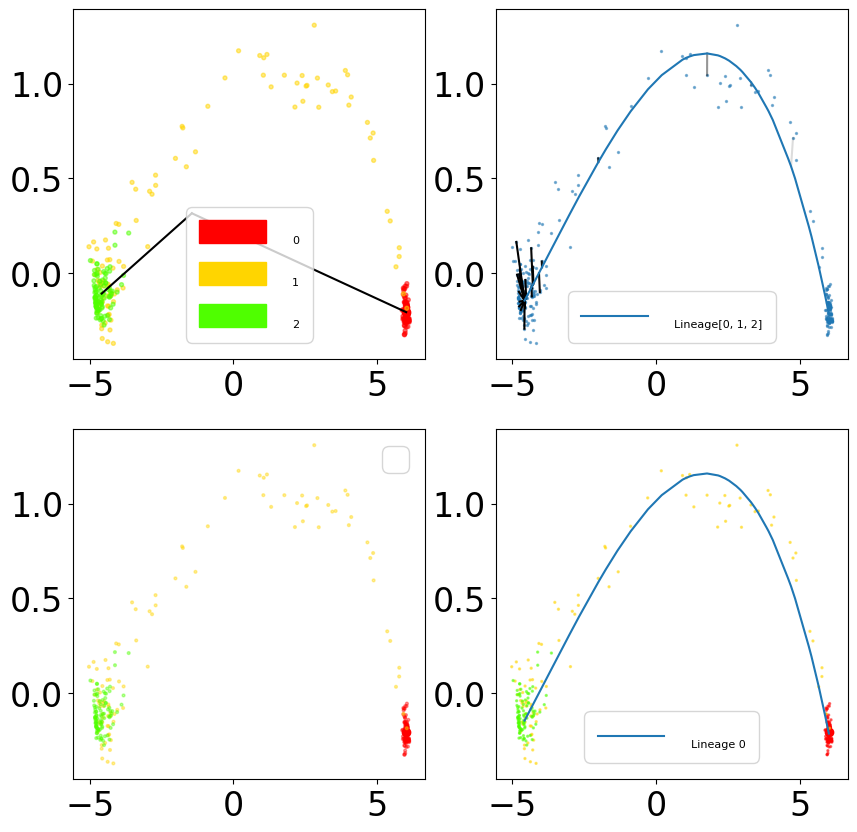

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)

slingshot = Slingshot(ad, celltype_key="celltype", obsm_key="X_umap", start_node=0, debug_level='verbose')


slingshot.fit(num_epochs=1, debug_axes=axes)

# Adjust legend size
for ax in axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.set_title(legend.get_title().get_text(), prop={'size': 10})  # Reduce legend title size
        for text in legend.get_texts():
            text.set_fontsize(8)  # Reduce legend item text size


In [19]:
pseudotime = slingshot.unified_pseudotime
ad.obs["pseudotime"] = slingshot.unified_pseudotime

print(type(slingshot.unified_pseudotime))  # Check the object type
print(slingshot.unified_pseudotime.shape)  # Check its dimensions
print(slingshot.unified_pseudotime[:5])    # Print first few values


<class 'numpy.ndarray'>
(300,)
[0.         0.00763148 0.06034511 0.07099188 0.        ]


Add splicing data to anndata object also

In [20]:
spliced_data = np.loadtxt("exprS_clean_jensgrn_jensgrn.txt") #spliced RNA
unspliced_data = np.loadtxt("exprU_clean_jensgrn_jensgrn.txt") #unspliced RNA

# Ensure the shape matches adata.X (genes x cells)
print(spliced_data.shape)  # Should be (num_genes, num_cells)
print(unspliced_data.shape)  # Should be (num_genes, num_cells)
print(ad.layers.keys())
# Transpose if necessary (AnnData assumes cells x genes)
if spliced_data.shape[1] == ad.n_obs and spliced_data.shape[0] == ad.n_vars:
    ad.layers["spliced"] = spliced_data.T  # Ensure it aligns with AnnData structure
    print('done w spliced')
else:
    raise ValueError("Shape mismatch! Check if genes and cells are correctly aligned.")

if unspliced_data.shape[1] == ad.n_obs and unspliced_data.shape[0] == ad.n_vars:
    ad.layers["unspliced"] = unspliced_data.T  # Ensure it aligns with AnnData structure
    print('done w unspliced')
else:
    raise ValueError("Shape mismatch! Check if genes and cells are correctly aligned.")

# Print splicing data info
print("spliced data shape:", ad.layers["spliced"].shape)
print("spliced data (first 5 genes, first 5 cells):\n", ad.layers["spliced"][:5, :5])
print("unspliced data shape:", ad.layers["unspliced"].shape)
print("unspliced data (first 5 genes, first 5 cells):\n", ad.layers["unspliced"][:5, :5])

# Print pseudotime data info
print("Pseudotime data shape:", ad.obs["pseudotime"].shape)
print("Pseudotime values (first 10 cells):\n", ad.obs["pseudotime"].head(10))
print(ad.layers.keys())
ad.write("custom_ad.h5ad")


(8, 300)
(8, 300)
KeysView(Layers with keys: spliced, unspliced)
done w spliced
done w unspliced
spliced data shape: (300, 8)
spliced data (first 5 genes, first 5 cells):
 [[17.89101  20.167843  8.771031 13.14711  17.41176 ]
 [17.106595 18.908989  8.903855 13.315025 18.724163]
 [16.622495 19.491639  9.296295 12.694583 17.899105]
 [17.220306 20.429534  9.253359 11.759838 17.276045]
 [17.45312  19.010511  8.873109 13.384992 15.887641]]
unspliced data shape: (300, 8)
unspliced data (first 5 genes, first 5 cells):
 [[4.132786 5.343596 2.351195 3.318577 4.364664]
 [3.675962 4.173924 2.761983 3.140888 4.471642]
 [4.529675 4.688408 2.148983 3.526078 4.825111]
 [3.330841 5.326097 1.861695 2.068515 3.585369]
 [4.07522  4.533038 2.025398 3.346507 4.044178]]
Pseudotime data shape: (300,)
Pseudotime values (first 10 cells):
 0    0.000000
1    0.007631
2    0.060345
3    0.070992
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.000000
9    0.000000
Name: pseudotime, dtype: float64
Ke

/var/folders/6s/mn0cx1qn7b901qdgrbh6z_hm0000gp/T/ipykernel_10676/332775482.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


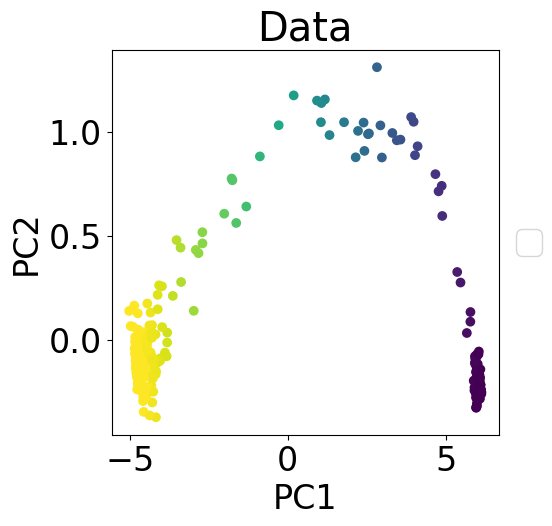

In [21]:
plt.rcParams["figure.figsize"] = (5,5)
        # PCAs:
from sklearn.decomposition import PCA
plt.rcParams["font.size"] = 24
pca = PCA()
Xt_all = pca.fit_transform(np.log2(data.T+1) ) 
plt.scatter(Xt_all[:,0],Xt_all[:,1], c=pseudotime )
#         for j in range(Nt):
#             idx = range(num_cells_per_time*j, num_cells_per_time*(j+1))
#             plt.plot(Xt_all[idx,0],Xt_all[idx,1],'o-')
#how to keep track of which cell is corr to which branch
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.show()

In [16]:
scv.pp.filter_and_normalize(ad, min_shared_counts=20, n_top_genes=2000)
ad

scv.tl.velocity_pseudotime(adata)
plt.hist( adata.obs['velocity_pseudotime'] )

NameError: name 'scv' is not defined